# Manejo de Datos Faltantes: Imputacion

### Importar librerias

In [1]:
import janitor  # limpiar datos
import matplotlib.pyplot as plt # visualizacion de datos
import missingno    # exploracion de valores faltantes
import nhanes.load  # libreria con los datos a analizar
import numpy as np  # calculos numericos
import pandas as pd # trabajar con dataframe
import scipy.stats  # trabjar con estadisticos
import seaborn as sns   #   visualizacion estadistica
# import session_info
# sklearn contiene los modelos a utilizar
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

### Importar Funciones Personalizadas

In [2]:
# permite utilizar funciones contenidas en otro notebook
%run '../utils2.ipynb'

### Configuracion de las Graficas

In [3]:
%matplotlib inline

# tamaño de los graficos
sns.set(
    rc={
        'figure.figsize':(8, 6)
    }
)

# estilo de los graficos
sns.set_style('whitegrid')

## El problema de trabajar con valores faltantes

In [4]:
# trabajamos con un dataset que nos provee statsmodels

airquality_df = (
    sm.datasets.get_rdataset('airquality') # datos de juguete
    .data   # acceder a los datos
    .clean_names(   # limpieza de datos
        case_type = 'snake'
    )
    .add_column('year',1973) # agregamos una columna de indicador
    .assign(    # convertimos una variable a una fecha
        date = lambda df: pd.to_datetime(df[['year', 'month', 'day']])
    )
    .sort_values(by = 'date')   # ordenamos el df segun la fecha
    .set_index('date')  # seteamos el indice con la fecha
)

airquality_df

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


In [5]:
# variables que contienen valores faltantes
(
    airquality_df
    .isna()
    .any()
)

ozone       True
solar_r     True
wind       False
temp       False
month      False
day        False
year       False
dtype: bool

Las variables ozone y solar_r contiene valores faltantes

Ajustemos un modelo de regresion lineal con statsmodel sobre los datos

In [6]:
# temperatura en funcion del ozono que contiene valores faltantes
(
    smf.ols(
        formula='temp ~ ozone',
        data=airquality_df
    )
    .fit() # ajuste del modelo sobre los datos
    .summary() # resumen estadistico del modelo
    .tables[0] # muestra solo el contenido de la tabla en la posicion 0
)

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Mon, 01 May 2023",Prob (F-statistic):,2.93e-18
Time:,08:50:48,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


vemos que se aplico el modelo OLS sobre un total de 116 observaciones con un R cuadrado de 0.488. Como se nota tampoco se obtuvo un error al ejecutarse el modelo a pesar que la variable ozono contiene missing. El dataset contiene mas de 150 observaciones por lo que el modelo omitio las observaciones con valores faltantes en la variable ozono

Ahora vamos a considerar otra variable y aplicar el modelo, en este caso solar_r

In [7]:
# temperatura en funcion del ozono y de solar_r
(
    smf.ols(
        formula='temp ~ ozone + solar_r',
        data=airquality_df
    )
    .fit() # ajuste del modelo sobre los datos
    .summary() # resumen estadistico del modelo
    .tables[0] # muestra solo el contenido de la tabla en la posicion 0
)

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Mon, 01 May 2023",Prob (F-statistic):,1.47e-16
Time:,08:50:48,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


En este modelo, tambien se perdieron observaciones ya que se aplico sobre 111. Se obtuvo un valor de R cuadrado de 0.491. Aunque se quisiera comparar ambos modelos mediante su valor de R cuadrado para saber cual de los dos se ajusto mejor, es un error hacerlo debido a que los modelos estan basados sobre diferentes numeros de observaciones.

## Reto: Datos de supervivientes

In [8]:
# dataframe de statsmodels con datos de prueba 
suvirval_df = sm.datasets.get_rdataset('flchain', 'survival').data
suvirval_df

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,97,F,1997,5.700,4.860,10,1.7,0,85,1,Circulatory
1,92,F,2000,0.870,0.683,1,0.9,0,1281,1,Neoplasms
2,94,F,1997,4.360,3.850,10,1.4,0,69,1,Circulatory
3,92,F,1996,2.420,2.220,9,1.0,0,115,1,Circulatory
4,93,F,1996,1.320,1.690,6,1.1,0,1039,1,Circulatory
...,...,...,...,...,...,...,...,...,...,...,...
7869,52,F,1995,1.210,1.610,6,1.0,0,4997,0,NaN
7870,52,F,1999,0.858,0.581,1,0.8,0,3652,0,NaN
7871,54,F,2002,1.700,1.720,8,NaN,0,2507,0,NaN
7872,53,F,1995,1.710,2.690,9,NaN,0,4982,0,NaN


In [9]:
# variables con valores faltantes
(
    suvirval_df
    .isna()
    .any()
)

age           False
sex           False
sample.yr     False
kappa         False
lambda        False
flc.grp       False
creatinine     True
mgus          False
futime        False
death         False
chapter        True
dtype: bool

Las variables creatinine y chapter contienen missing

In [10]:
# cantidad de valores faltantes por variable

(
    suvirval_df
    .isnull()
    .sum()
)

age              0
sex              0
sample.yr        0
kappa            0
lambda           0
flc.grp          0
creatinine    1350
mgus             0
futime           0
death            0
chapter       5705
dtype: int64

Hay 1350 missing para la variable creatinine y 5705 para chapter

### Ajusta algunos modelos para predecir si una persona va a sobrevivir o no utilizando a las variables con valores faltantes como predictoras

In [11]:
# Modelo 1
# death en funcion de creatinine

(
    smf.ols(
        formula='death ~ creatinine',
        data=suvirval_df
    )
    .fit() # ajuste del modelo sobre los datos
    .summary() # resumen estadistico del modelo
    .tables[0] # muestra solo el contenido de la tabla en la posicion 0
)

Dep. Variable:,death,R-squared:,0.025
Model:,OLS,Adj. R-squared:,0.025
Method:,Least Squares,F-statistic:,165.0
Date:,"Mon, 01 May 2023",Prob (F-statistic):,2.59e-37
Time:,08:50:50,Log-Likelihood:,-4089.4
No. Observations:,6524,AIC:,8183.
Df Residuals:,6522,BIC:,8196.
Df Model:,1,,
Covariance Type:,nonrobust,,


Este modelo solo considera 6524 de las 7874 observaciones que contiene el dataframe con un R cuadrado de 0.025

In [12]:
# Modelo 2
# death en funcion de creatinine y el sexo

(
    smf.ols(
        formula='death ~ creatinine + sex',
        data=suvirval_df
    )
    .fit() # ajuste del modelo sobre los datos
    .summary() # resumen estadistico del modelo
    .tables[0] # muestra solo el contenido de la tabla en la posicion 0
)

Dep. Variable:,death,R-squared:,0.026
Model:,OLS,Adj. R-squared:,0.026
Method:,Least Squares,F-statistic:,88.05
Date:,"Mon, 01 May 2023",Prob (F-statistic):,1.85e-38
Time:,08:50:50,Log-Likelihood:,-4084.0
No. Observations:,6524,AIC:,8174.
Df Residuals:,6521,BIC:,8194.
Df Model:,2,,
Covariance Type:,nonrobust,,


El modelo ,2 al igual que el modelo 1, solo considera 6524 observaciones con un R cuadrado de 0.026. Para este caso, ambos modelos pueden compararse debido a que se basan en la misma cantidad de observaciones.

In [13]:
# Modelo 3
# death en funcion de creatinine y chapter

(
    smf.ols(
        formula='death ~ creatinine + chapter',
        data=suvirval_df
    )
    .fit() # ajuste del modelo sobre los datos
    .summary() # resumen estadistico del modelo
    .tables[0] # muestra solo el contenido de la tabla en la posicion 0
)

/home/jbernal/anaconda3/envs/data/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Dep. Variable:,death,R-squared:,-inf
Model:,OLS,Adj. R-squared:,-inf
Method:,Least Squares,F-statistic:,-121.6
Date:,"Mon, 01 May 2023",Prob (F-statistic):,1.00
Time:,08:50:51,Log-Likelihood:,63518.
No. Observations:,1962,AIC:,-1.270e+05
Df Residuals:,1945,BIC:,-1.269e+05
Df Model:,16,,
Covariance Type:,nonrobust,,


El modelo 3 solo considera 1962 de las 7874 observaciones del dataframe lo que es un numero muy bajo en relacion del total. Es por ello que arroja valores erroneos para R cuadrado.

## Preparando datos: National Health and Nutrition Examination Survey

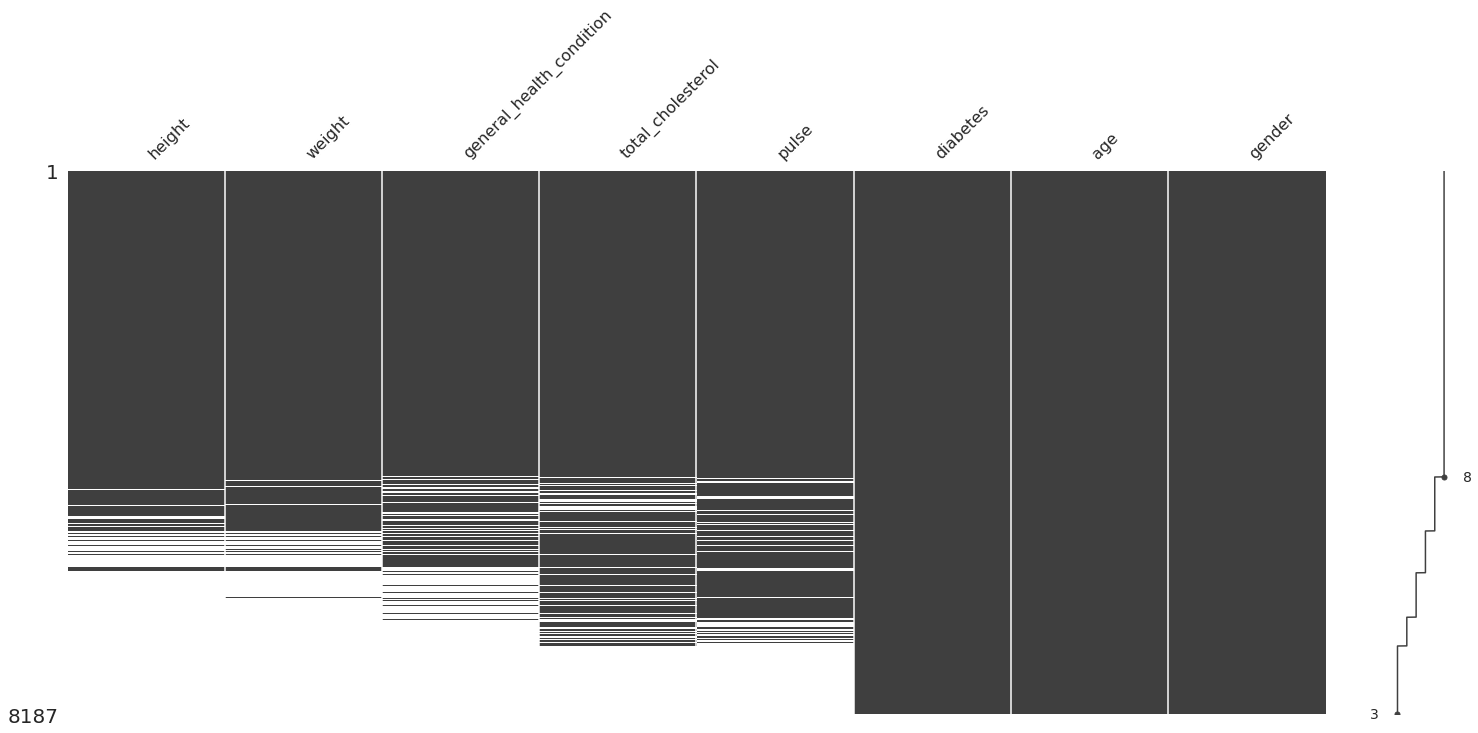

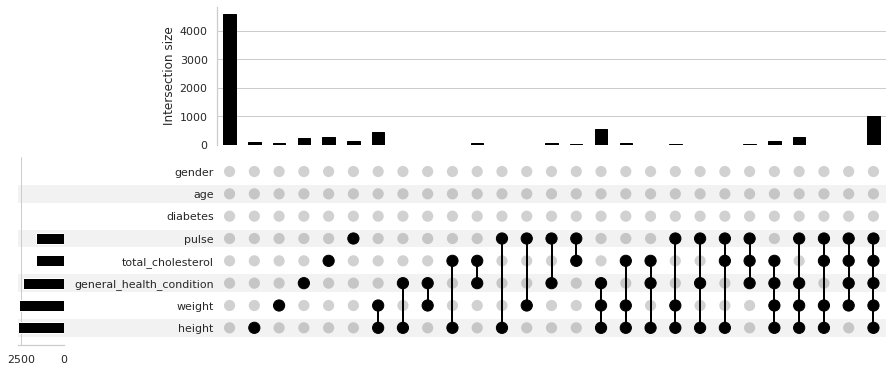

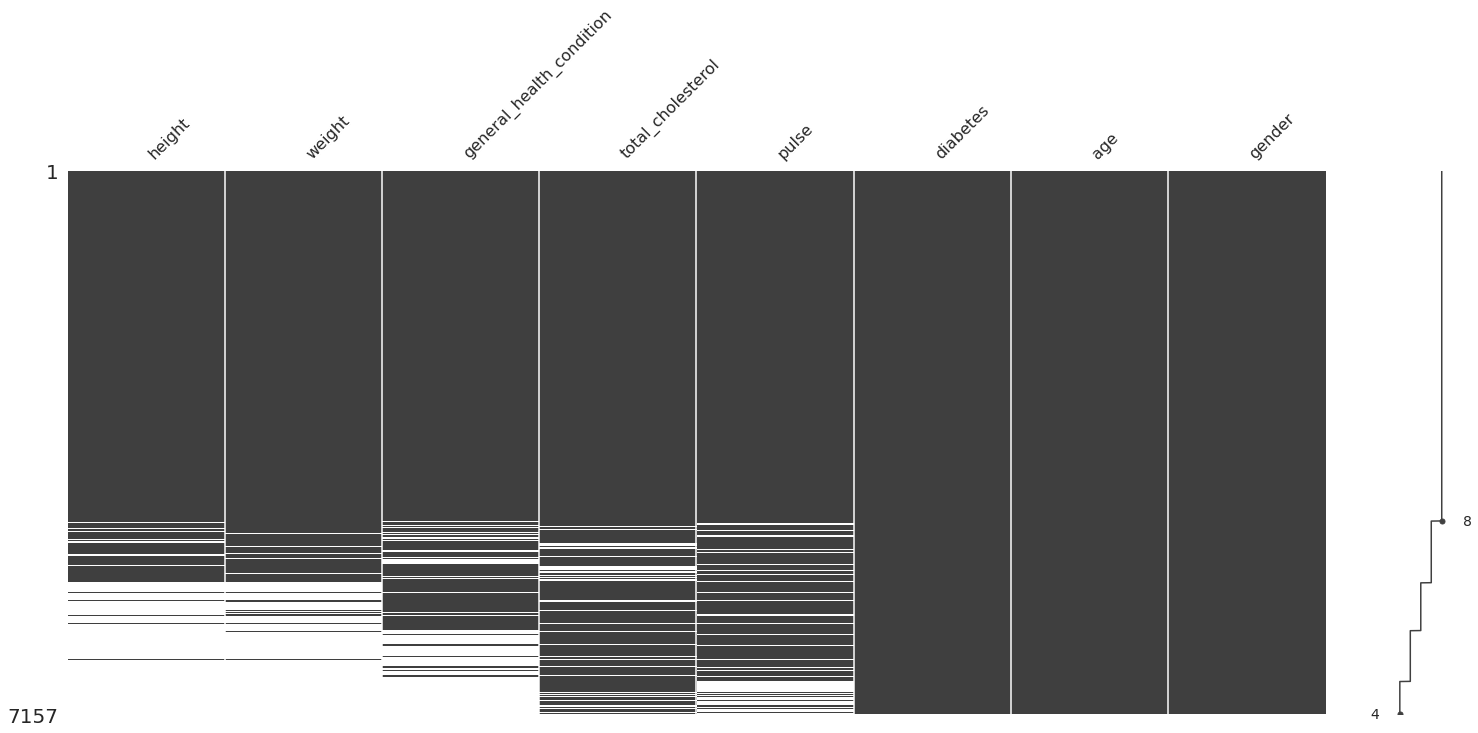

In [14]:
# cargar los datos externos
%run download_data_and_load.ipynb

## Consideracion y Evaluacion de los distintos tipos de valores faltantes

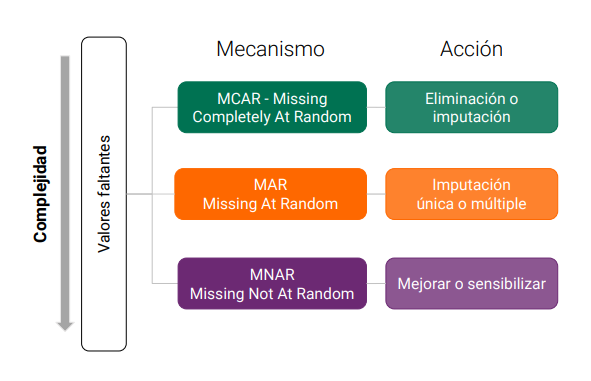

## Prueba de Hipotesis con TTest

### Existe alguna diferencia entre hombres y mujeres con la presencia o ausencia de valores en la variables Peso?

Exploraremos si la presencia o ausencia de valores faltantes es diferentes entre hombres y mujeres respecto al Peso

In [15]:

female_weight, male_weight = (
    nhanes_df
    .select_columns('gender','weight') # extraer las columnas de interes del dataframe
    .transform_column(                 # trnasformar en valores booleanos los elementos de Peso
        'weight',
        lambda x: x.isna(),
        elementwise = False
    )
    .groupby('gender')                 # agrupar segun el genero
    .weight
    .pipe(
        lambda df:(                    # extraer los dos grupos
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

In [16]:
female_weight

SEQN
93705.0     False
93709.0     False
93714.0     False
93719.0      True
93721.0     False
            ...  
102941.0     True
102943.0    False
102948.0    False
102954.0    False
102955.0     True
Name: weight, Length: 3665, dtype: bool

In [17]:
male_weight

SEQN
93706.0     False
93707.0      True
93711.0     False
93712.0     False
93713.0     False
            ...  
102946.0    False
102947.0    False
102949.0    False
102953.0    False
102956.0    False
Name: weight, Length: 3492, dtype: bool

In [18]:
# aplicacion de la prueba Ttest
scipy.stats.ttest_ind(
    a = female_weight,  # primer grupo
    b = male_weight,    # segundo grupo
    alternative='two-sided' # metodo de t-test
) 
# con el metodo utilizado lo que estamos preguntando es si existe una diferencia entre 
# la ausencia o presencia de valores de Peso? si el valor del modelo estadistico es mayor
# a 0.05 no se puede definir o rechazar la hipotesis nula de que exista alguna diferencia

Ttest_indResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239)

Como pvalue es mayor a 0.05 no podemos rechazar la hipotesis nula es decir no podemos asegurar que exista alguna diferencia entre las personas con valores faltantes. Esto sugiere que los datos no estan perdidos al azar al menos para la categoria de genero.

### Existe alguna diferencia entre hombres y mujeres con la presencia o ausencia de valores en la variable altura?

In [19]:
female_height, male_height = (
    nhanes_df
    .select_columns(['gender', 'height']) # seleccion de las variables
    .transform_column(  # transforma en booleanos los valores de height
        'height',
        lambda x: x.isna(),
        elementwise = False
    )
    .groupby('gender')  # agrupa segun el genero
    .height
    .pipe(
        lambda df:(     # extrae los dos grupos
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

In [20]:
female_height

SEQN
93705.0     False
93709.0     False
93714.0     False
93719.0      True
93721.0     False
            ...  
102941.0     True
102943.0    False
102948.0    False
102954.0    False
102955.0     True
Name: height, Length: 3665, dtype: bool

In [21]:
male_height

SEQN
93706.0     False
93707.0      True
93711.0     False
93712.0     False
93713.0     False
            ...  
102946.0    False
102947.0    False
102949.0    False
102953.0    False
102956.0    False
Name: height, Length: 3492, dtype: bool

In [22]:
# aplicacion de la prueba Ttest
# hipotesis nula: la media de ambas distribuciones son desiguales

scipy.stats.ttest_ind(
    a = female_height,
    b = male_height,
    alternative= 'two-sided'
)

Ttest_indResult(statistic=-1.0441004739954949, pvalue=0.29647418035378503)

Como el valor de p es mayor que el umbral de 0.05 se rechaza la hipotesis nula, es decir, no hay suficientes pruebas para asegurar que exista una diferencia entre hombres y mujeres en funcion de la altura. Los datos no estan perdidos al azar.

### Existe alguna diferencia entre hombre y mujeres por la presencia o ausencia de valores en la variable colesterol?

In [23]:
female_cholesterol, male_cholesterol = (
    nhanes_df
    .select_columns(['gender', 'total_cholesterol'])
    .transform_column(
        'total_cholesterol',
        lambda x: x.isna(),
        elementwise = False
    )
    .groupby('gender')
    .total_cholesterol
    .pipe(
        lambda df:(
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

In [24]:
female_cholesterol

SEQN
93705.0     False
93709.0     False
93714.0     False
93719.0     False
93721.0     False
            ...  
102941.0    False
102943.0    False
102948.0    False
102954.0    False
102955.0    False
Name: total_cholesterol, Length: 3665, dtype: bool

In [25]:
male_cholesterol

SEQN
93706.0     False
93707.0     False
93711.0     False
93712.0     False
93713.0     False
            ...  
102946.0    False
102947.0    False
102949.0    False
102953.0    False
102956.0    False
Name: total_cholesterol, Length: 3492, dtype: bool

In [26]:
# aplicamos la prueba de Ttest
# hipotesis nula: la media de ambas distribuciones son desiguales

scipy.stats.ttest_ind(
    a = female_cholesterol,
    b = male_cholesterol,
    alternative='two-sided'
)

Ttest_indResult(statistic=-0.7000351630218239, pvalue=0.48392810483409965)

Como el valor de p es menor que el umbral de 0.05, se rechaza la hipotesis nula es decir, no podemos asegurar que exista alguna diferencia entre mujeres y hombres por la presencia o ausencia de total cholesterol.

## Nueva herramienta para explorar valores faltantes

### Explorar la relacion de variables categoricas en funcion de la ausencia en otra variable mediante un grafico de Mosaico

In [27]:
# Grafico de Mosaico para las variables weight, general_health_condition, gender

(
    nhanes_df
    .select_columns('weight', 'general_health_condition', 'gender') # seleccionar columnas
    .assign(  # asignar valores NA y !NA para la variable weight dependiendo si hay o no missing
        weight = lambda df: df.weight.isna().replace([True, False], ['NA', '!NA'])
    )   # cuantificar las apariciones que existen por cada combinacion de las 3 variables
    .groupby(
        ['gender', 'general_health_condition', 'weight'],
        dropna=False, # no eliminar los valores faltantes de health
        as_index= True
    )
    .size()
)

gender  general_health_condition  weight
Female  Excellent                 !NA        212
                                  NA          65
        Fair or                   !NA        549
                                  NA          42
        Good                      !NA       1102
                                  NA         113
        Poor?                     !NA         94
                                  NA           3
        Very good                 !NA        659
                                  NA         103
        NaN                       !NA        234
                                  NA         489
Male    Excellent                 !NA        273
                                  NA          62
        Fair or                   !NA        508
                                  NA          31
        Good                      !NA       1056
                                  NA         112
        Poor?                     !NA         70
                            

Nos muestra las tres categorias tabuladas conjuntamente con sus conteos de aparicion (frecuencia)

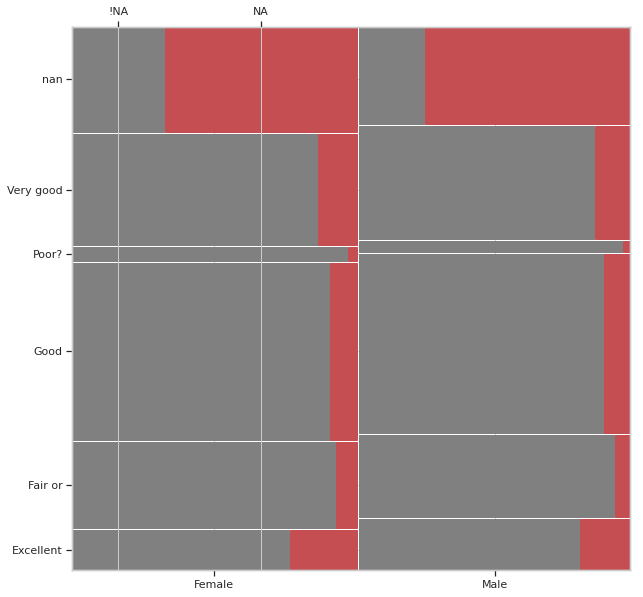

In [28]:
# visualizacion mediante un grafico de Mosaico

# size de la grafica
fig, ax = plt.subplots(figsize=(10,10))

(
    nhanes_df
    .select_columns('weight', 'general_health_condition', 'gender') # seleccionar columnas
    .assign(  # asignar valores NA y !NA para la variable weight dependiendo si hay o no missing
        weight = lambda df: df.weight.isna().replace([True, False], ['NA', '!NA'])
    )   # cuantificar las apariciones que existen por cada combinacion de las 3 variables
    .groupby(
        ['gender', 'general_health_condition', 'weight'],
        dropna=False, # no eliminar los valores faltantes de health
        as_index= True
    )
    .size()
    .pipe(
        lambda df: mosaic(
            data=df,
            properties= lambda key: {'color':'r' if 'NA' in key else 'gray'},
            horizontal=True,
            axes_label=True,
            title='',
            labelizer=lambda key:'', # coloca los nombres de las variables dentro del cuadro
            ax=ax
        )
    )
);

En la categoria pobreza, hay muy pocas observaciones mientras que el estado de salud 'Muy bien' tiene una mayor cantidad pero no mas que el estado de salud 'Bien'. Por otro lado, a las personas que responden en el estado de salud con 'Muy bien' les falta a muchas de las observaciones la variable Peso y en mayor proporcion que a las personsa que reponden 'Bien'

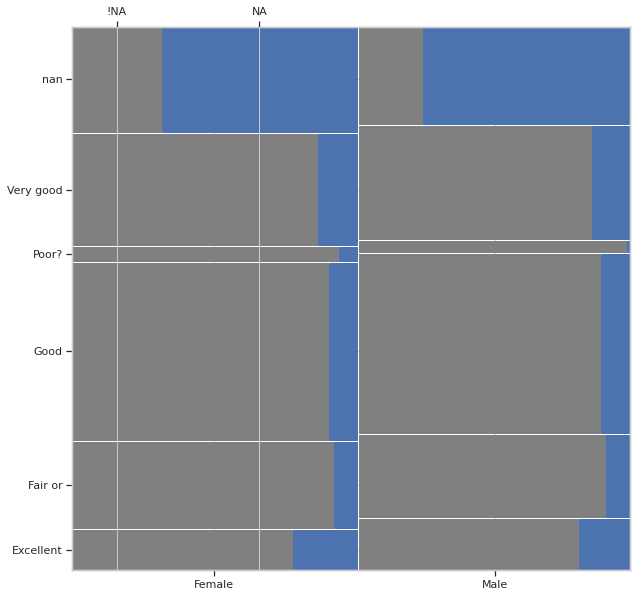

In [29]:
# Grafico de Mosaico para las variables gender, general_health_condition, height

fig, ax = plt.subplots(figsize=(10,10))

(
    nhanes_df
    .select_columns(['height', 'general_health_condition', 'gender'])  # seleccionar columnas
    .assign(    # asignar NA y !NA a la variable height dependiendo si hay o no missing
        height = lambda df: df.height.isna().replace([True, False], ['NA', '!NA'])
    )
    .groupby(
        ['gender', 'general_health_condition', 'height'],
        dropna=False,
        as_index = True
    )
    .size()
    .pipe(
        lambda df: mosaic(
            data= df,
            properties= lambda key: {'color':'b' if 'NA' in key else 'gray'},
            horizontal=True,
            axes_label=True,
            title='',
            labelizer=lambda key:'',
            ax=ax
        )
    )
);

## Tratamiento de Variables Categoricas para imputacion

## Codificacion Ordinal

In [30]:
# creamos una copia de los datos
nhanes_transformed_df = nhanes_df.copy(deep=True) # deep para asegurar que tiene una direccion en memoria distinta


Dado un conjunto de datos con dos caracteristicas, encontraremos los valores unicos por caracteristica y los transformaremos utilizando una codificacion ordinal

In [31]:
X = [['Male'], ['Female'], ['Female']]
X

[['Male'], ['Female'], ['Female']]

In [32]:
# creamos un encoder para agrupar la informacion y codificarla
encoder = sklearn.preprocessing.OrdinalEncoder() 

In [33]:
# codificamos la lista anterior
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

El hombre quedo con la codificacion 1 y la mujer con 0. Para cuando hay muchas categorias utilizamos el metodos categories_

In [34]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

Calcular la inversa de la transformacion de manera que si hay un 1 aparezca un hombre y si hay un 0 aparezca una mujer

In [35]:
encoder.inverse_transform([[1],[1],[0]])

array([['Male'],
       ['Male'],
       ['Female']], dtype=object)

### Aplicando la codificacion ordinal a todas las variables categoricas

In [36]:
# obtener las variables de tipo objeto y categorica
nhanes_df.select_dtypes(include=[object, 'category'])

,general_health_condition,gender
SEQN,,
93705.0,Good,Female
93706.0,Very good,Male
93707.0,Good,Male
93709.0,NaN,Female
93711.0,Very good,Male
...,...,...
102949.0,Excellent,Male
102953.0,Fair or,Male
102954.0,Good,Female


In [37]:
# obtener solo los nombres de las variables con valores de tipo object y category
categorical_columns = nhanes_df.select_dtypes(include=[object, 'category']).columns

categorical_columns

Index(['general_health_condition', 'gender'], dtype='object')

In [38]:
# funcion que permite componer instrucciones de transfomacion en los datos

categorical_transformer = sklearn.compose.make_column_transformer(
    #   transformador                         variables a transformar
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder='passthrough' # permite omitir las demas variables para que no las transforme
)

categorical_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 Index(['general_health_condition', 'gender'], dtype='object'))])

In [39]:
# nuevo dataframe transformado

(
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df)
    )
)

,0,1,2,3,4,5,6,7
0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
1,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
2,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
3,NaN,0.0,62.0,200.0,176.0,74.0,0.0,75.0
4,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
7152,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
7153,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
7154,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0
7155,4.0,0.0,NaN,NaN,150.0,74.0,0.0,14.0


In [40]:
# colocar nuevamente los nombres de las variables

nhanes_transformed_df = (
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns=categorical_transformer.get_feature_names_out(),
        index=nhanes_df.index   # vuelve a los indices del dataframe original
    )
    .rename_columns(
        function = lambda x: x.removeprefix('ordinalencoder__')
    )
    .rename_columns(
        function = lambda x: x.removeprefix('remainder__')
    )
)

nhanes_transformed_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


Se obtiene las variables con un prefijo: ordinalencoder para las que fueron transformada y remainder para las que no fueron transformada.

## One Hot Encoding

In [41]:
# creamos una copia del dataframe

nhanes_transformed_df2 = nhanes_df.copy(deep=True)

Existen dos metodos para generar un one hot encoding: pandas.get_dummies() y sklearn.preprocessing.OneHotEncoder()

### Metodo de Pandas

In [42]:
# Metodo de Pandas

(
    nhanes_transformed_df2  # dataframe
    .select_columns('general_health_condition') # variable categorica
    .pipe(pd.get_dummies) 
)

,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good
SEQN,,,,,
93705.0,0,0,1,0,0
93706.0,0,0,0,0,1
93707.0,0,0,1,0,0
93709.0,0,0,0,0,0
93711.0,0,0,0,0,1
...,...,...,...,...,...
102949.0,1,0,0,0,0
102953.0,0,1,0,0,0
102954.0,0,0,1,0,0


In [43]:
# El problema con el metodo de Pandas

(
    nhanes_transformed_df2  # dataframe
    .select_columns('general_health_condition') # variable categorica
    .head(10)
    .pipe(pd.get_dummies) 
)


,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Very good
SEQN,,,
93705.0,0,1,0
93706.0,0,0,1
93707.0,0,1,0
93709.0,0,0,0
93711.0,0,0,1
93712.0,0,1,0
93713.0,0,0,1
93714.0,0,1,0
93715.0,1,0,0


Al considerar solo las primeras 10 observaciones no toma en cuenta las demas categorias, solo las que estan contenidas en las primeras 10. Por otro lado, no considera una columna para los valores faltantes. Es util para representar los datos de manera rapida pero para fines practicos donde se requiera operaciones, inversas o entrenar un modelo con unas mismas dimensiones no funciona

### Metodo de sklearn

In [44]:
# creamos un transformador

#              funcion para construir los transformadores requeridos
transformer = sklearn.compose.make_column_transformer(
    # transformacion ordinal                  variable categorica
    (sklearn.preprocessing.OrdinalEncoder(), ['gender']),
    # transformacion one hot                  variable categorica
    (sklearn.preprocessing.OneHotEncoder(), ['general_health_condition']),
    remainder='passthrough' # omision de la transformacion de las demas variables
)

In [45]:
# dataframe con los valores transformados

nhanes_transformed_df2 = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df),
        columns=transformer.get_feature_names_out(),
        index=nhanes_df.index   # vuelve a los indices del dataframe original
    )
    .rename_columns(
        function = lambda x: x.removeprefix('ordinalencoder__')
    )
    .rename_columns(
        function = lambda x: x.removeprefix('remainder__')
    )
    .rename_columns(
       function = lambda x: x.removeprefix('onehotencoder__')
    )
)

nhanes_transformed_df2

,gender,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good,general_health_condition_nan,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,,,,,,
93705.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [46]:
# acceder a las categorias de health

(
    transformer
    .named_transformers_
    .get('onehotencoder')
    .categories_
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

In [47]:
# extraer solo una categoria. Para este caso extraer Good

(
    transformer
    .named_transformers_
    .get('onehotencoder')
    .inverse_transform(
        X = [[0,0,1,0,0,0]]     # vector que representa la categoria Good
    )
)

array([['Good']], dtype=object)

## Imputacion de un unico valor

In [48]:
# imputacion para la variable altura

(
    nhanes_df
    # utilizamos un metodo janitor
    .transform_column(
     'height',
     lambda x: x.fillna(x.mean()),
     elementwise=False
    )
)

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
SEQN,,,,,,,,
93705.0,63.00000,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.00000,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,66.25656,NaN,Good,189.0,100.0,0,13.0,Male
93709.0,62.00000,200.0,NaN,176.0,74.0,0,75.0,Female
93711.0,69.00000,142.0,Very good,238.0,62.0,0,56.0,Male
...,...,...,...,...,...,...,...,...
102949.0,72.00000,180.0,Excellent,201.0,96.0,0,33.0,Male
102953.0,65.00000,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.00000,150.0,Good,172.0,78.0,0,41.0,Female


En este caso la media es de 66.256, valor con el cual se sustituye los valores faltantes

In [49]:
# obtener la media de la columna height

(
    nhanes_df
    # utilizamos un metodo janitor
    .transform_column(
     'height',
     lambda x: x.fillna(x.mean()),
     elementwise=False
    )
    .height
    .mean()
)

66.25655976676525

El valor de la media en general no se altera debido a la imputacion, se mantiene

### Visualizacion de los valores imputados

In [50]:
# matriz de sombra para las avariables weight y height
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix2(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
)

,height,weight,height_imp,weight_imp
SEQN,,,,
93705.0,63.00000,165.000000,False,False
93706.0,68.00000,145.000000,False,False
93707.0,66.25656,178.462993,True,True
93709.0,62.00000,200.000000,False,False
93711.0,69.00000,142.000000,False,False
...,...,...,...,...
102949.0,72.00000,180.000000,False,False
102953.0,65.00000,218.000000,False,False
102954.0,66.00000,150.000000,False,False


<AxesSubplot:xlabel='height', ylabel='weight'>

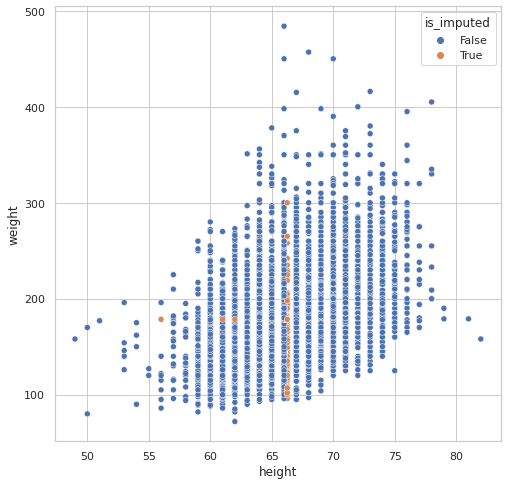

In [51]:
# visualizacion de los valores imputados mediante un scatterplot

plt.figure(figsize=(8, 8))

(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix2(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
    .missing.scatter_imputation_plot(x="height", y="weight")
)

La imputacion hecha no rompe la estructura de los datos ni la relacion entre variables, los puntos imputados no se estan saliendo de los puntos reales por lo que es una buena imputacion.  

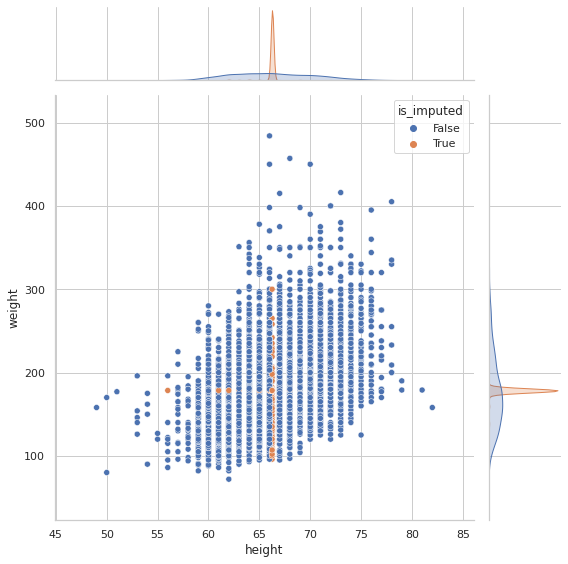

In [52]:
# visualizacion de la distribucion de los datos imputados en el scatterplot

(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix2(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
    .missing.scatter_imputation_plot(
    x="height", 
    y="weight",
    show_marginal = True,   # muestra la distribucion a los costado
    height = 8             # tamano del grafico
    )
)

## Imputacion por llenado hacia atras y hacia adelante

### Llenado hacia adelante

In [53]:
# llenado hacia adelante
# los valores faltantes se sustituyen por el valor antecesor

(
    nhanes_df   # dataframe
    .select_columns('height', 'weight') # variables numericas
    .fillna(method = 'ffill')
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,68.0,145.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


In [54]:
# metodo alternativo de Pandas. Llenado hacia adelante

(
    nhanes_df                           # dataframe
    .select_columns('height', 'weight') # variables numericas
    #.fillna(method = 'ffill')
    .ffill()                            # metodos de Pandas
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,68.0,145.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


### Llenado hacia atras

In [55]:
# llenado hacia atras
# los valores faltantes se sustituyen por el valor sucesor

(
    nhanes_df   # dataframe
    .select_columns('height', 'weight') # variables numericas
    .fillna(method = 'bfill')
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,62.0,200.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


In [56]:
# metodo alternativo de Pandas. Llenado hacia atras

(
    nhanes_df                           # dataframe
    .select_columns('height', 'weight') # variables numericas
    #.fillna(method = 'bfill')
    .bfill()                            # metodos de Pandas
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,62.0,200.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


### Imputacion dentro de dominios

Para que la imputacion tenga mas sentido debemos considerar las variables categoricas. Podemos tratar las variables categoricas como dominios donde nuestra variable de interes toma solo valores dentro del mismo. Es decir, en cada categoria puede existir un rango distinto de valores para la variable de interes. Por lo tanto, haciendo imputaciones dentro de los dominios puedes conservar la estructura de los datos y las relaciones entre las variables

In [57]:
# la variable a la que vamos a imputar los valores es a weight

(
    nhanes_df
    # seleccionamos las variables. Hay dos categoricas y tres numericas
    .select_columns('weight', 'height', 'gender', 'diabetes', 'general_health_condition')
    # ordenamos los grupos segun nuestro interes 
    # para este caso, primero el genero, seguido de diabetes, su estado de salud y finalmente la altura
    .sort_values(
        by = ['gender', 'diabetes', 'general_health_condition', 'height'],
        ascending = True
    )# realizamos la imputacion con el metodo transform
    .transform_column(
        'weight',   # variable de interes
        lambda x: x.ffill(),    # imputacion hacia adelante
        elementwise = False     # pasa una serie y no un unico valor
    )
)

,weight,height,gender,diabetes,general_health_condition
SEQN,,,,,
94421.0,115.0,56.0,Female,0,Excellent
94187.0,130.0,59.0,Female,0,Excellent
95289.0,162.0,59.0,Female,0,Excellent
97967.0,130.0,59.0,Female,0,Excellent
99125.0,105.0,59.0,Female,0,Excellent
...,...,...,...,...,...
96561.0,290.0,74.0,Male,1,NaN
96954.0,175.0,NaN,Male,1,NaN
97267.0,175.0,NaN,Male,1,NaN


De esta manera estamos garantizando que la imputacion esta tomando valores adecuados para cada dominio. Sin embargo, puede ocurrir que al traerse el valor antecesor se obtenga un valor de otro dominio generando ruido en los datos. Para ello se utiliza la funcion groupby lo cual permite agrupar los datos por las variables categoricas y luego ordenarlos por las variables numericas para asi realizar la imputacion y evitar este problema.

## Imputacion por Interpolacion

<AxesSubplot:xlabel='date'>

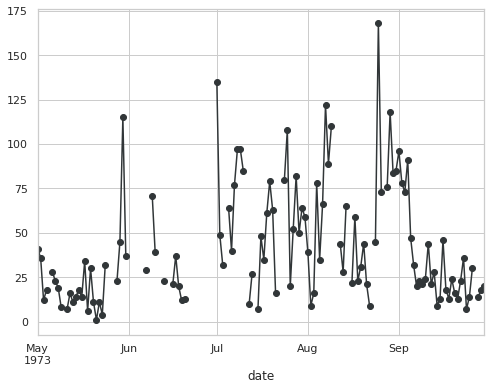

In [58]:
# utilizamos el dataset de calidad del aire debido a que contiene datos temporales

(
    airquality_df
    .select_columns('ozone')    # variable de interes
    .pipe(                      # graficamos los puntos del ozono
        lambda df: (
            df.ozone.plot(
                color='#313638',
                marker='o'
            )
        )
    )
)

Hay puntos que no estan conectados, la linea no es continua lo que indica que existen datos faltantes

### Interpolacion por llenado

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

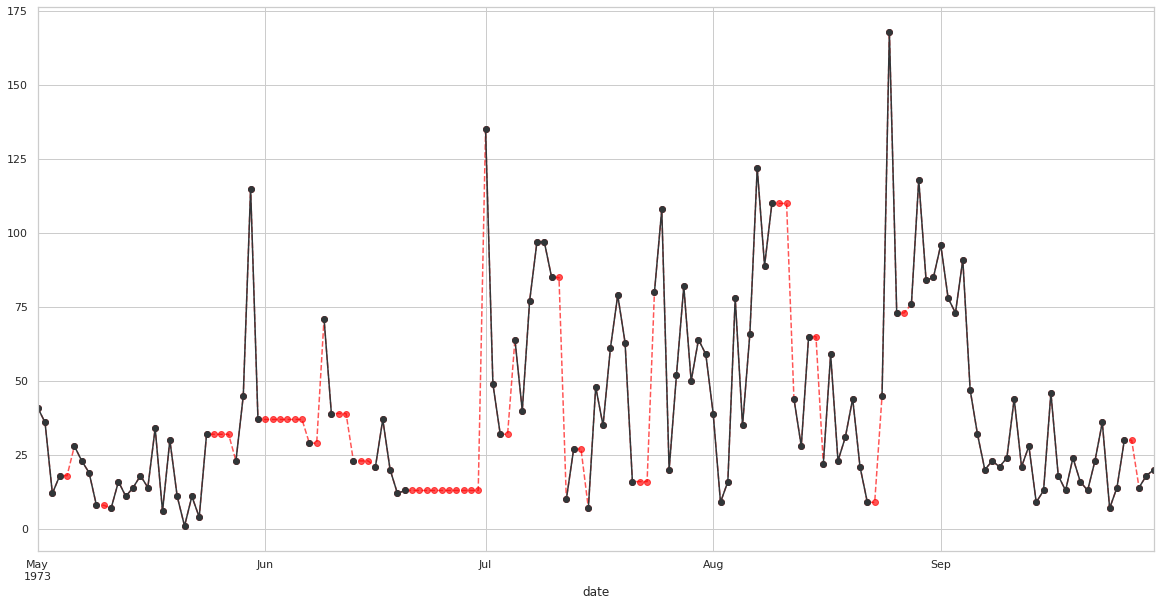

In [59]:
# utilizamos la imputacion por relleno hacia adelante

plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns('ozone')    # variable de interes
    .pipe(                      # graficamos los puntos del ozono
        lambda df: (
            df.ozone.ffill().plot(
                color='red',
                marker = 'o',
                alpha=6/9,
                linestyle='dashed'
            ),
            df.ozone.plot(
                color='#313638',
                marker='o'
            )
        )
    )
)

Toma el valor del punto anterior y lo rellena hacia adelante. Esta imputacion no sigue el comportamiento de los datos.

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

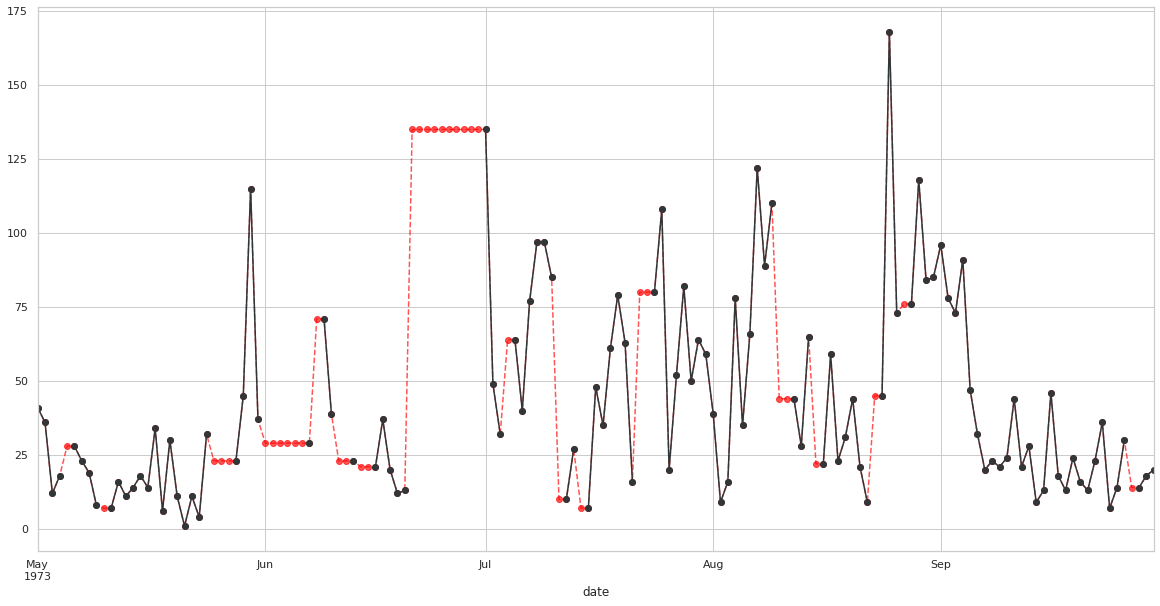

In [60]:
# utilizamos la imputacion por relleno hacia atras

plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns('ozone')    # variable de interes
    .pipe(                      # graficamos los puntos del ozono
        lambda df: (
            df.ozone.bfill().plot(
                color='red',
                marker = 'o',
                alpha=6/9,
                linestyle='dashed'
            ),
            df.ozone.plot(
                color='#313638',
                marker='o'
            )
        )
    )
)

Toma el valor del putno posterior y lo rellena hacia atras. Al igual que la imputacion anterior, no sigue el comportamiento de los datos.

### Interpolacion lineal

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

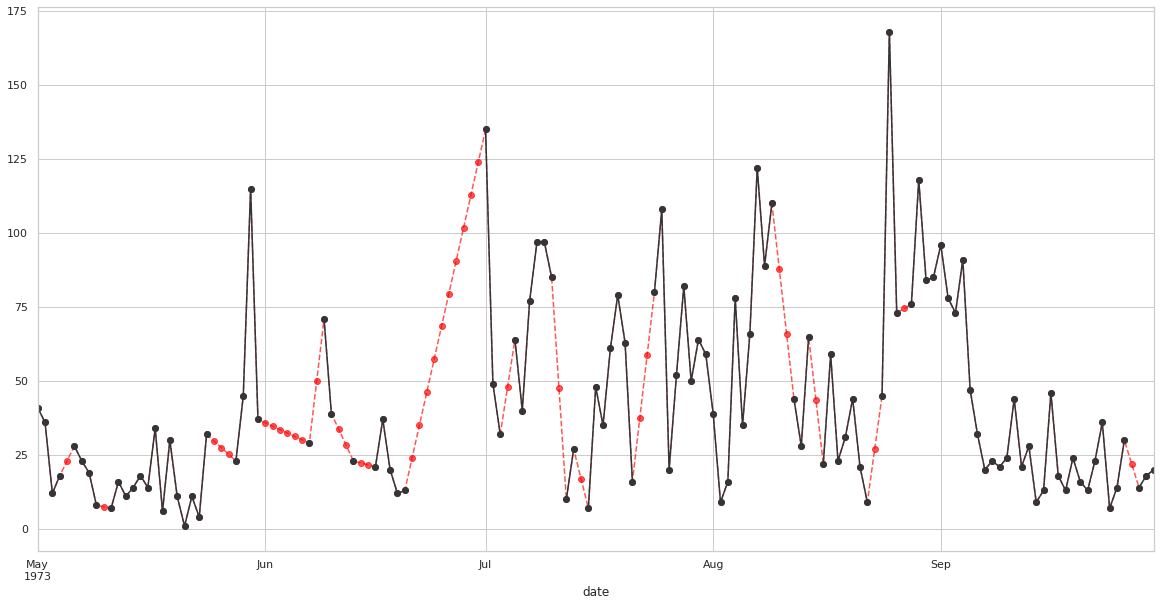

In [61]:
# utilizamos el metodo lineal de interpolate()

plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns('ozone')    # variable de interes
    .pipe(                      # graficamos los puntos del ozono
        lambda df: (
            df.ozone.interpolate(method = 'linear').plot(
                color='red',
                marker = 'o',
                alpha=6/9,
                linestyle='dashed'
            ),
            df.ozone.plot(
                color='#313638',
                marker='o'
            )
        )
    )
)

Genera una linea recta entre dos puntos conocidos para establecer los puntos que son desconocidos. La imputacion lineal si se ajusta al comportamiento de los datos

### Interpolacion cuadratica

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

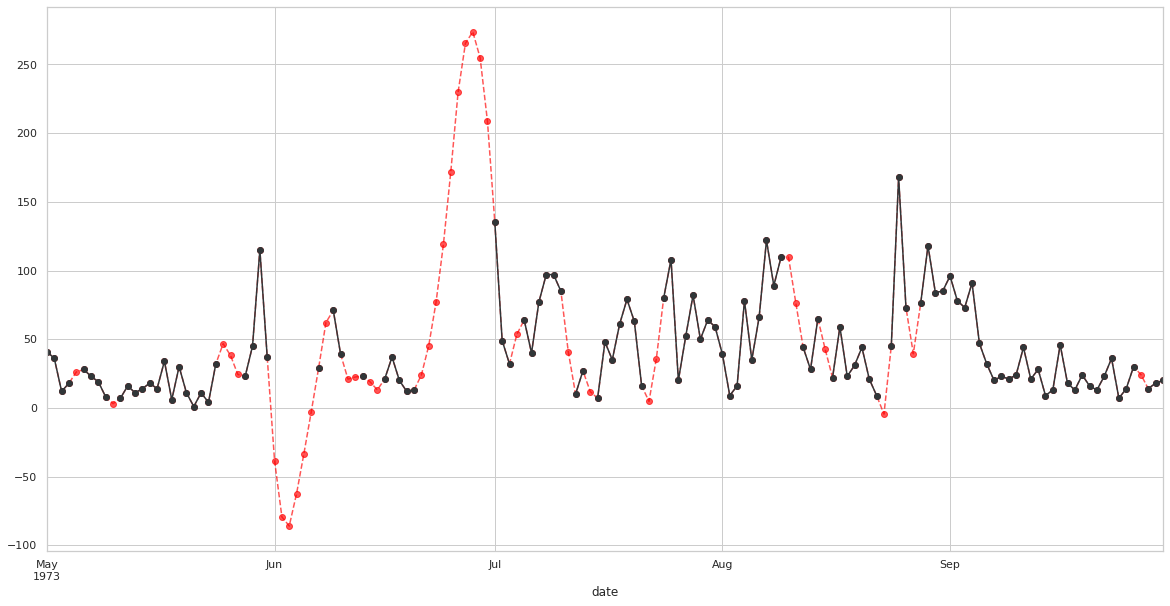

In [62]:
# utilizamos el metodo cuadsratico de interpolate()

plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns('ozone')    # variable de interes
    .pipe(                      # graficamos los puntos del ozono
        lambda df: (
            df.ozone.interpolate(method = 'quadratic').plot(
                color='red',
                marker = 'o',
                alpha=6/9,
                linestyle='dashed'
            ),
            df.ozone.plot(
                color='#313638',
                marker='o'
            )
        )
    )
)

Establece una relacion cuadratica de interpolacion. A pesar que se ajusta bien en los datos, tiende a crear puntos fuera del comportamiento habitual lo que indica que no es una buena imputacion. Valores de ozonos por debajo de cero

### Interporlacion valores mas cercanos

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

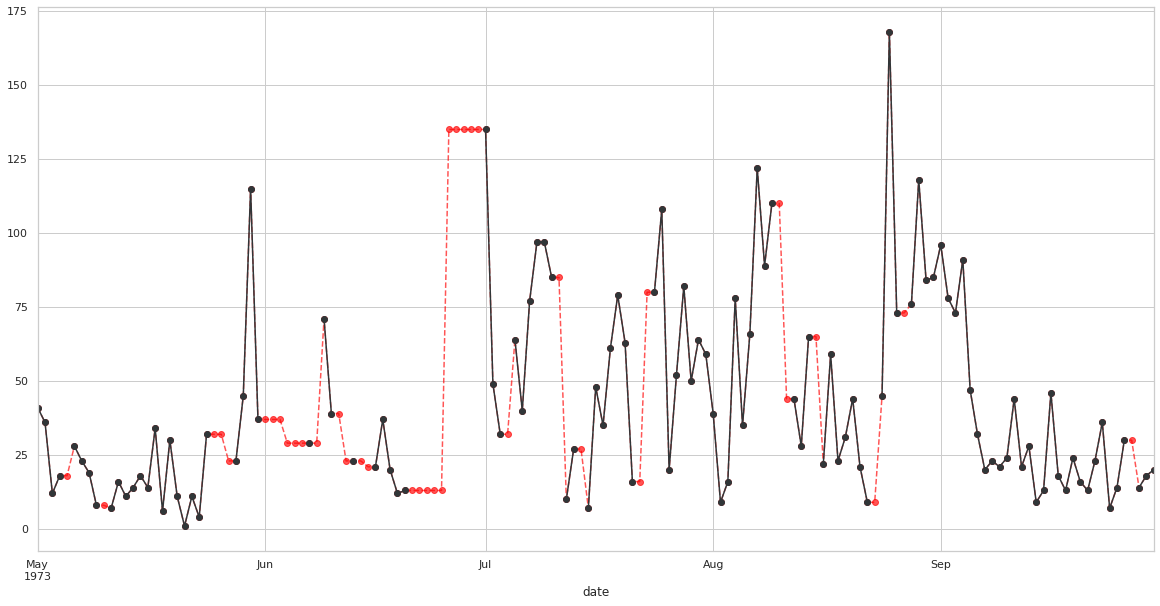

In [63]:
# utilizamos el metodo cuadsratico de interpolate()

plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns('ozone')    # variable de interes
    .pipe(                      # graficamos los puntos del ozono
        lambda df: (
            df.ozone.interpolate(method = 'nearest').plot(
                color='red',
                marker = 'o',
                alpha=6/9,
                linestyle='dashed'
            ),
            df.ozone.plot(
                color='#313638',
                marker='o'
            )
        )
    )
)

Utiliza el llenado hacia adelante o hacia atras dependiendo de si el valor conocido es mas cercano hacia la izquierda o derecha del valor faltantes para luego imputarlo. No se ajusta al comportamiento de los datos

### Interpolacion Polinomica

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

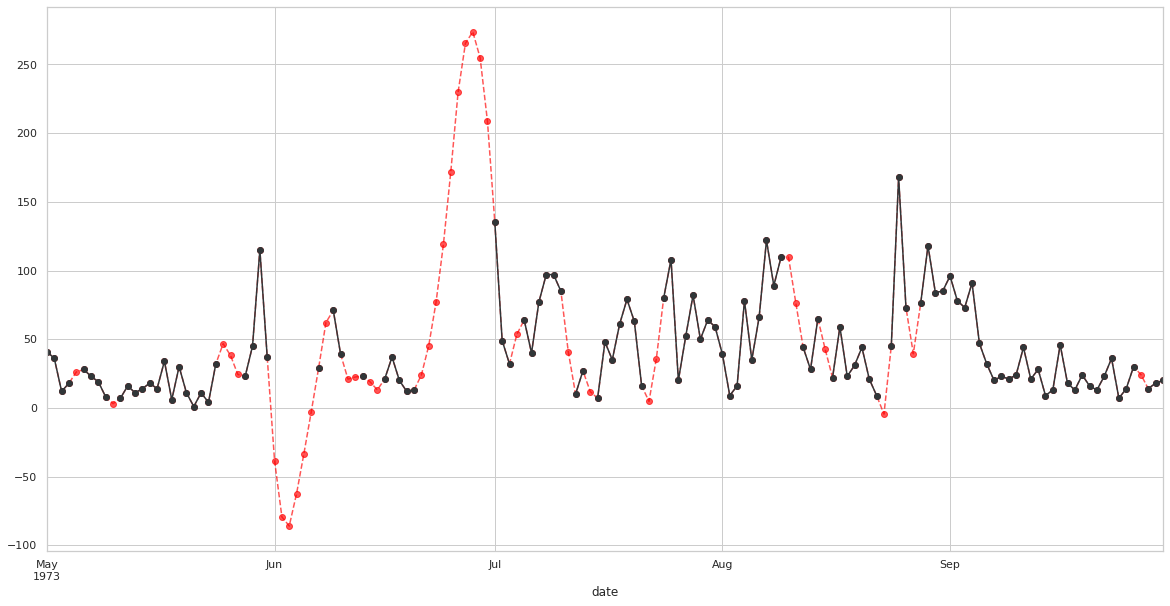

In [64]:
# utilizamos el metodo polinomial de interpolate()

plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns('ozone')    # variable de interes
    .pipe(                      # graficamos los puntos del ozono
        lambda df: (
            df.ozone.interpolate(method = 'polynomial', order=2).plot(
                color='red',
                marker = 'o',
                alpha=6/9,
                linestyle='dashed'
            ),
            df.ozone.plot(
                color='#313638',
                marker='o'
            )
        )
    )
)

### Interpolacion Cubica

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

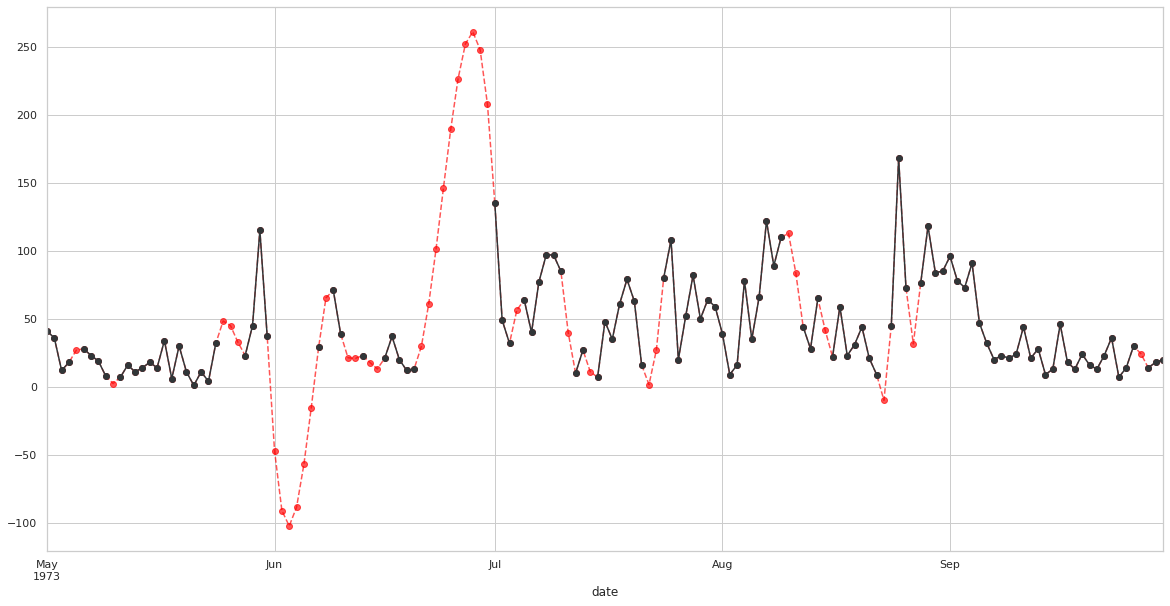

In [65]:
# utilizamos el metodo cubico de interpolate()

plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns('ozone')    # variable de interes
    .pipe(                      # graficamos los puntos del ozono
        lambda df: (
            df.ozone.interpolate(method = 'cubic', order=2).plot(
                color='red',
                marker = 'o',
                alpha=6/9,
                linestyle='dashed'
            ),
            df.ozone.plot(
                color='#313638',
                marker='o'
            )
        )
    )
)

### Interpolacion Temporal

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

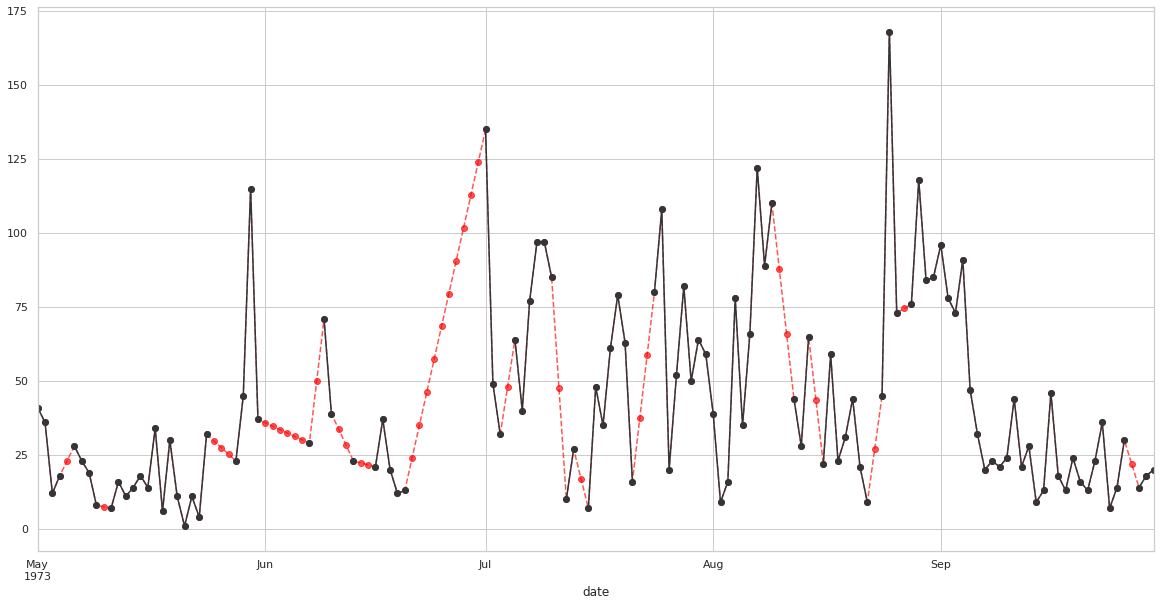

In [66]:
# utilizamos el metodo time de interpolate()

plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns('ozone')    # variable de interes
    .pipe(                      # graficamos los puntos del ozono
        lambda df: (
            df.ozone.interpolate(method = 'time', order=2).plot(
                color='red',
                marker = 'o',
                alpha=6/9,
                linestyle='dashed'
            ),
            df.ozone.plot(
                color='#313638',
                marker='o'
            )
        )
    )
)

### Interpolacion Slineal

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

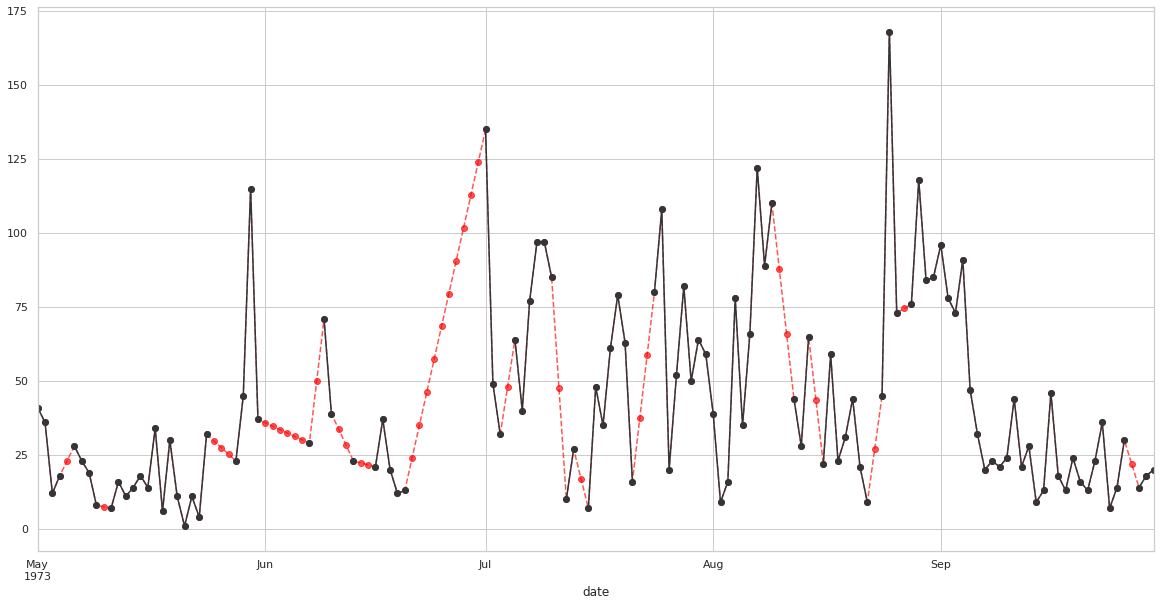

In [67]:
# utilizamos el metodo cubico de interpolate()

plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns('ozone')    # variable de interes
    .pipe(                      # graficamos los puntos del ozono
        lambda df: (
            df.ozone.interpolate(method = 'slinear', order=2).plot(
                color='red',
                marker = 'o',
                alpha=6/9,
                linestyle='dashed'
            ),
            df.ozone.plot(
                color='#313638',
                marker='o'
            )
        )
    )
)

### Interpolacion akima

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

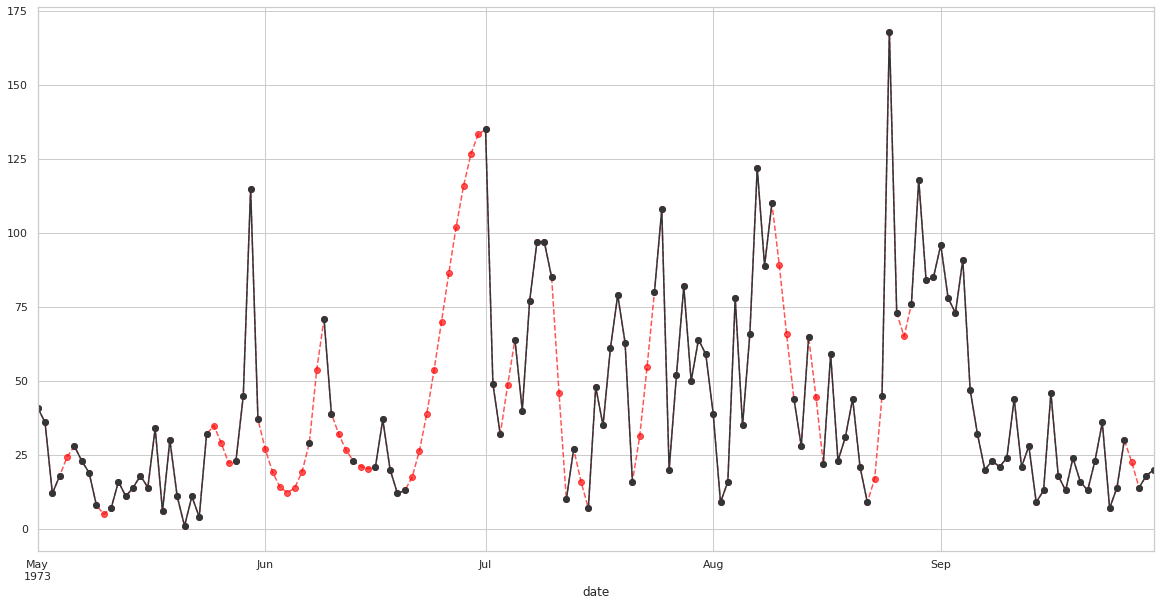

In [68]:
# utilizamos el metodo cubico de interpolate()

plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns('ozone')    # variable de interes
    .pipe(                      # graficamos los puntos del ozono
        lambda df: (
            df.ozone.interpolate(method = 'akima', order=2).plot(
                color='red',
                marker = 'o',
                alpha=6/9,
                linestyle='dashed'
            ),
            df.ozone.plot(
                color='#313638',
                marker='o'
            )
        )
    )
)

### Guardar los datos de la interpolacion que mas se ajusta

In [69]:
airquality_df['ozone'] = airquality_df.ozone.interpolate(method='linear')

airquality_df

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,23.0,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,22.0,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


Hemos imputados los valores faltantes de ozono con el metodo de interpolacion lineal

## Imputacion por KNN

In [70]:
nhanes_df

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male
...,...,...,...,...,...,...,...,...
102949.0,72.0,180.0,Excellent,201.0,96.0,0,33.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


In [71]:
# utilizamos el dataframe con los datos categoricos convertidos en numeros
nhanes_transformed_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [72]:
# implementamos la imputacion con el algoritmo de knn

# imputador con knn
knn_imputer = sklearn.impute.KNNImputer()

In [73]:
# creamos una copia del df con los datos transformados

nhanes_df_knn = nhanes_transformed_df.copy(deep=True)

In [74]:
# imputamos los missing

# agregamos los valores al nuevo df                  sobreescribimos        redondeamos valores   
nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_transformed_df).round()

nhanes_df_knn

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,69.0,130.0,189.0,100.0,0.0,13.0
93709.0,2.0,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


### Vizualizacion de la imputacion por KNN

<AxesSubplot:xlabel='height', ylabel='weight'>

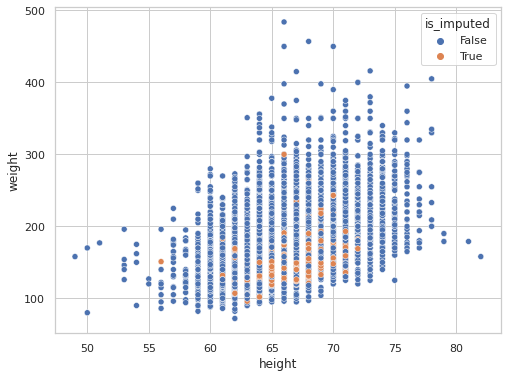

In [75]:
(   # matriz de sombra
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix2(True, False, suffix='_imp', only_missing=True)
        ],
        axis=1
    )   # visualizacion mediantes un scatterplot de dos variables numericas
    .missing.scatter_imputation_plot(
        x = 'height',
        y = 'weight'
    )
)

### Ordenamiento por cantidad de variables faltantes

Ordenar los datos por la cantidad de variables faltantes nos da cierto rigor al momento de la imputacion. Esto se logra comenzando con definir las distancias entre valores existentes para luego predecir o imputar valores que no existen repitiendo el proceso paso a paso hasta lograr la imputacion completa de los datos. Algunos algoritmos implementan esta tecnica por defecto

In [76]:
# imputador con knn
knn_imputer = sklearn.impute.KNNImputer()

# copia del df                        ordenamos las variables por la cantidad de missing de forma ascendente
nhanes_df_knn = nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True).copy(deep=True)

# agregamos los valores imputados al nuevo df         ajustamos los datos ordenados por la cantidad de variables faltantes                                                                              redondeamos valores   
nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True).copy(deep=True)).round()

nhanes_df_knn

,gender,diabetes,age,pulse,total_cholesterol,general_health_condition,weight,height
SEQN,,,,,,,,
93705.0,0.0,0.0,66.0,52.0,157.0,2.0,165.0,63.0
93706.0,1.0,0.0,18.0,82.0,148.0,4.0,145.0,68.0
93707.0,1.0,0.0,13.0,100.0,189.0,2.0,130.0,69.0
93709.0,0.0,0.0,75.0,74.0,176.0,2.0,200.0,62.0
93711.0,1.0,0.0,56.0,62.0,238.0,4.0,142.0,69.0
...,...,...,...,...,...,...,...,...
102949.0,1.0,0.0,33.0,96.0,201.0,0.0,180.0,72.0
102953.0,1.0,0.0,42.0,78.0,182.0,1.0,218.0,65.0
102954.0,0.0,0.0,41.0,78.0,172.0,2.0,150.0,66.0


<AxesSubplot:xlabel='height', ylabel='weight'>

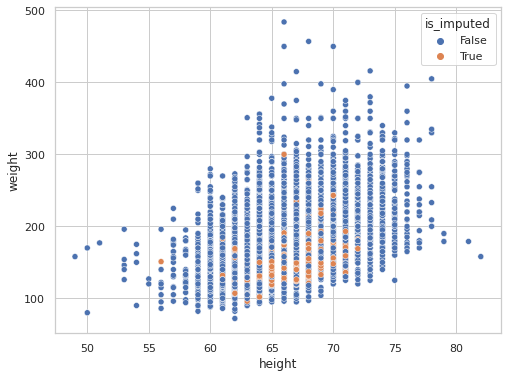

In [77]:
# traemos el codigo de visualizacion 

(   # matriz de sombra
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix2(True, False, suffix='_imp', only_missing=True)
        ],
        axis=1
    )   # visualizacion mediantes un scatterplot de dos variables numericas
    .missing.scatter_imputation_plot(
        x = 'height',
        y = 'weight'
    )
)

Aunque ambas imputaciones son similares, puede darse el caso dependiendo del software que aplicando este truco te ayude a conseguir mejores rendimientos en el conjunto de datos

## Imputacion basada en Modelos

Cuando se utiliza un modelo para imputar, en principio no aceptan valores faltantes por lo que el primer paso es imputar los valores faltantes con dummies. Luego se utiliza el modelo y se va iterando hasta que los valores que hemos sustituido con dummies no cambien. Justo alli se llega a una optima imputacion. 

### Preparacion de los datos

In [78]:
# preparamos los datos de la variable a imputar

nhanes_model_df= (
    nhanes_df
    .select_columns('height', 'weight', 'gender', 'age')    # seleccionamos columnas
    .sort_values(by='height')   # ordenamos en funcion de height
    #   sustituir los valores faltantes con dummies
    .transform_column(  
        'weight',   # variable de interes
        lambda x: x.ffill(),
        elementwise = False
    )   #   matriz de sombra con el sufijo imp
    .missing.bind_shadow_matrix2(
        True,
        False,
        suffix='_imp',
        only_missing=False   # matriz de sombra para todas las variables
    )
)

nhanes_model_df

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,49.0,158.0,Female,80.0,False,False,False,False
96508.0,50.0,170.0,Female,46.0,False,False,False,False
97877.0,50.0,80.0,Female,29.0,False,False,False,False
102379.0,51.0,177.0,Female,71.0,False,False,False,False
93816.0,53.0,146.0,Female,80.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102915.0,NaN,107.0,Female,14.0,True,False,False,False
102926.0,NaN,107.0,Female,15.0,True,False,False,False
102941.0,NaN,107.0,Female,14.0,True,False,False,False


### Preparacion del modelo

In [79]:
# para este ejemplo vamos a utilizar la regresion lineal como modelo

height_ols = (
    nhanes_model_df
    .pipe(
        lambda df: smf.ols('height ~ weight + gender + age', data=df)
    )
    .fit()
)

### Generacion de los valores imputados mediante el modelo

In [80]:
# obtener solo las observaciones con valores nulos en la variable height

(
    nhanes_model_df
    .pipe(
        lambda df: df[df.height.isna()]
    )
)

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
93707.0,NaN,158.0,Male,13.0,True,False,False,False
93719.0,NaN,158.0,Female,13.0,True,False,False,False
93733.0,NaN,158.0,Female,11.0,True,False,False,False
93736.0,NaN,158.0,Male,11.0,True,False,False,False
93737.0,NaN,158.0,Male,8.0,True,False,False,False
...,...,...,...,...,...,...,...,...
102915.0,NaN,107.0,Female,14.0,True,False,False,False
102926.0,NaN,107.0,Female,15.0,True,False,False,False
102941.0,NaN,107.0,Female,14.0,True,False,False,False


In [81]:
# utilizamos el modelo para generar los valores imputados

ols_imputed_values = (
    nhanes_model_df
    .pipe(
        lambda df: df[df.height.isna()]
    )
    # aplicamos el modelo. Los valores imputados se redondean debido a que son enteros
    .pipe( 
    lambda df: height_ols.predict(df).round()
    )
)

ols_imputed_values

SEQN
93707.0     69.0
93719.0     64.0
93733.0     64.0
93736.0     69.0
93737.0     69.0
            ... 
102915.0    63.0
102926.0    63.0
102941.0    63.0
102945.0    68.0
102955.0    63.0
Length: 1669, dtype: float64

### Sustitucion de los valores imputados en el Dataset 

In [82]:
# sustituimos los valores imputados generados con 
# el modelo en la variable asociada

nhanes_model_df.loc[nhanes_model_df.height.isna(), ['height']] = ols_imputed_values

nhanes_model_df

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,49.0,158.0,Female,80.0,False,False,False,False
96508.0,50.0,170.0,Female,46.0,False,False,False,False
97877.0,50.0,80.0,Female,29.0,False,False,False,False
102379.0,51.0,177.0,Female,71.0,False,False,False,False
93816.0,53.0,146.0,Female,80.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102915.0,63.0,107.0,Female,14.0,True,False,False,False
102926.0,63.0,107.0,Female,15.0,True,False,False,False
102941.0,63.0,107.0,Female,14.0,True,False,False,False


### Visualizacion de los valores imputados

<AxesSubplot:xlabel='weight', ylabel='height'>

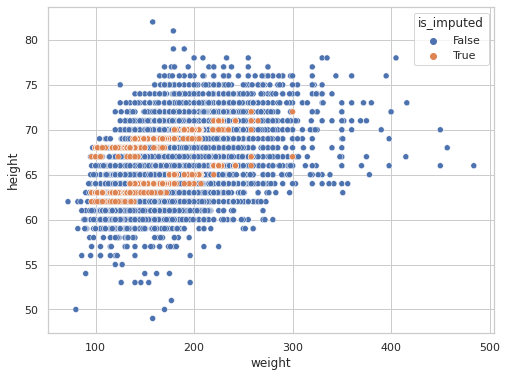

In [83]:
(
    nhanes_model_df
    .missing
    .scatter_imputation_plot(
        x = 'weight',   # variable independiente
        y = 'height'    # variable objetivo
    )
)

La grafica nos muestra la imputacion de la variable height en funcion de la variable weight. Observamos dos bloques de datos lo que podria indicar que se trata de la diferencia en peso entre mujeres y hombres 

El siguiente paso para aprovechar mejor el modelo es repetir todos los pasos anteriores pero en la preparacion de los datos, en vez de utilizar los valores dummies para weight, utilizamos la variable height con los valores imputados por el modelo. De esta manera ahora se busca imputar los valores de la variable weight en vez de los de height que ya han sido imputados.

## Imputacion Multiples por Ecuaciones Encadenadas (MICE)

### Creamos el imputador con MICE

In [84]:
# crea las copias, las analiza y regresa un solo conjunto de datos. 
# Tambien puedes pedir que retorne todos las copias 

mice_imputer = sklearn.impute.IterativeImputer(
    estimator=BayesianRidge(),  # metodo seleccionado para estimar los missing
    initial_strategy='mean',    # estimador seleccionado
    imputation_order='ascending'# ordena las variables segun la cantidad de valores faltantes
    
)

### Copia de los datos transformados

In [85]:
# creamos una copia de los datos ya transformado

nhanes_mice_df = nhanes_transformed_df.copy(deep=True)

### Ajuste, transformaciony sustitucion de los datos imputados

In [86]:
# ajustar y transformar los datos

# puedes pasar como parametro nhanes_df o nhanes_mice_df
# por defecto pasamos nhanes_df porque sobreescribe los valores del dataframe que copiamos
# redondeamos los numeros en este caso
# agrega los valores imputados al dataset

nhanes_mice_df.iloc[:, :] =  mice_imputer.fit_transform(nhanes_transformed_df).round()

nhanes_mice_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,70.0,200.0,189.0,100.0,0.0,13.0
93709.0,2.0,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


### Matriz de sombra para la Visualizacion

In [87]:
# Matriz de sombra sobre los datos para la visualizacion

# guradamos toda la operacion en el mismo dataframe
nhanes_mice_df = pd.concat( # concatenar los datos imputados y los datos originales
    [
        nhanes_mice_df,
        nhanes_df.missing.create_shadow_matrix2(
            True,
            False,
            only_missing=False,
            suffix='_imp',
        )
    ],
    axis=1 # aplica sobre la matriz de sombra
)


### Visualizacion de los valores imputados

<AxesSubplot:xlabel='height', ylabel='weight'>

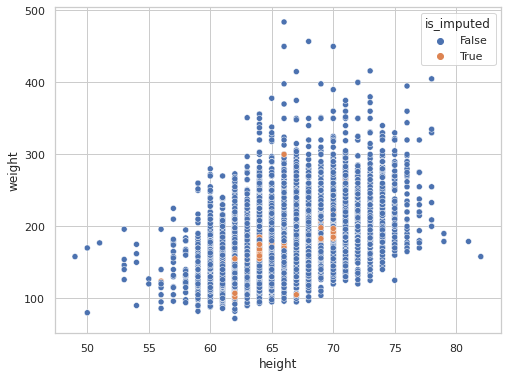

In [88]:
# Visualizacion de la variable height y weight 

nhanes_mice_df.missing.scatter_imputation_plot(
    x = 'height',
    y = 'weight'
)

## Transformacion Inversa de los datos

In [89]:
# utilizamos los datos nhane_mice_df que son los que queremos transformar
# creamos una copia del dataframe

nhanes_imputed_df = nhanes_mice_df.copy(deep=True)

In [90]:
#   mostrar las transformaciones hechas a los datos

(
    categorical_transformer # funcion que transforma los valores
    .named_transformers_    # nombre de las transformaciones realizadas a los datos
)

{'ordinalencoder': OrdinalEncoder(), 'remainder': 'passthrough'}

In [91]:
# accedemos al codificador de interes
# en este caso a ordinalencoder

(
    categorical_transformer # funcion que transforma los valores
    .named_transformers_    # nombre de las transformaciones realizadas a los datos
    .ordinalencoder
)

OrdinalEncoder()

In [92]:
# finalmente accedemos a la funcion inversa para aplicar sobre los datos ordinalencoder
# las variables estan guardadas en categorical_columns

(
    categorical_transformer # funcion que transforma los valores
    .named_transformers_    # nombre de las transformaciones realizadas a los datos
    .ordinalencoder
    .inverse_transform(
        X=nhanes_mice_df[categorical_columns]
    )
)

array([['Good', 'Female'],
       ['Very good', 'Male'],
       ['Good', 'Male'],
       ...,
       ['Good', 'Female'],
       ['Very good', 'Female'],
       ['Good', 'Male']], dtype=object)

In [93]:
# guardamos los datos transformados en el df nhanes_imputed_df

nhanes_imputed_df[categorical_columns] = (
    categorical_transformer # funcion que transforma los valores
    .named_transformers_    # nombre de las transformaciones realizadas a los datos
    .ordinalencoder
    .inverse_transform(
        X=nhanes_mice_df[categorical_columns]
    )
)

nhanes_imputed_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age,height_imp,weight_imp,general_health_condition_imp,total_cholesterol_imp,pulse_imp,diabetes_imp,age_imp,gender_imp
SEQN,,,,,,,,,,,,,,,,
93705.0,Good,Female,63.0,165.0,157.0,52.0,0.0,66.0,False,False,False,False,False,False,False,False
93706.0,Very good,Male,68.0,145.0,148.0,82.0,0.0,18.0,False,False,False,False,False,False,False,False
93707.0,Good,Male,70.0,200.0,189.0,100.0,0.0,13.0,True,True,False,False,False,False,False,False
93709.0,Good,Female,62.0,200.0,176.0,74.0,0.0,75.0,False,False,True,False,False,False,False,False
93711.0,Very good,Male,69.0,142.0,238.0,62.0,0.0,56.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,Excellent,Male,72.0,180.0,201.0,96.0,0.0,33.0,False,False,False,False,False,False,False,False
102953.0,Fair or,Male,65.0,218.0,182.0,78.0,0.0,42.0,False,False,False,False,False,False,False,False
102954.0,Good,Female,66.0,150.0,172.0,78.0,0.0,41.0,False,False,False,False,False,False,False,False


### Comparar como lucen las variables imputadas antes y depues de la imputacion

In [94]:
# cantidad para cada categoria del estado de salud. Valores sin imputar

nhanes_df.general_health_condition.value_counts()

Good         2383
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: general_health_condition, dtype: int64

In [95]:
# cantidad para cada categoria del estado de salud. Valores imputados

nhanes_imputed_df.general_health_condition.value_counts()

Good         3743
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: general_health_condition, dtype: int64

### Verificar que no hayan quedado valores faltantes

In [96]:
nhanes_imputed_df.missing.number_missing()


0